In [1]:
import sys
print(sys.version)

3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]


In [2]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pandarallel

import requests
import pprint
from joblib import dump, load


from IPython.display import clear_output

import re
from re import sub, findall, match

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from pandarallel import pandarallel

In [3]:
def get_gcs_data (bucket_name, folder_name, file_name, path_local):
    url = 'https://storage.googleapis.com/' + bucket_name + '/' + folder_name + '/' + file_name
    r = requests.get(url)
    open(path_local + '/' + file_name , 'wb').write(r.content)

In [4]:
path_yelp_data = '/home/jupyter/yelp'
path_yelp_model = '/home/jupyter/data/yelp/yelp_model/'

os.makedirs(path_yelp_data, exist_ok=True)
os.makedirs(path_yelp_model, exist_ok=True)

In [5]:
bucket_name = 'msca-bdp-data-open'
folder_name = 'yelp/yelp_model'
file_name = ['model.joblib', 
             'nb.joblib', 'logreg.joblib', 'svm.joblib',
             # 'nb_small.joblib', 'logreg_small.joblib', 'svm_small.joblib'
            ]
path_local = path_yelp_model

os.makedirs(path_local, exist_ok=True)

for file in file_name:
    get_gcs_data (bucket_name = bucket_name,
                 folder_name = folder_name,
                 file_name = file,
                 path_local = path_local)
    print('Downloaded: ' + file)

Downloaded: model.joblib
Downloaded: nb.joblib
Downloaded: logreg.joblib
Downloaded: svm.joblib


In [6]:
!ls -l /home/jupyter/data/yelp/yelp_model/

total 1848492
-rw-r--r-- 1 jupyter jupyter 522995808 May 27 02:13 logreg.joblib
-rw-r--r-- 1 jupyter jupyter   7661465 May 27 02:13 model.joblib
-rw-r--r-- 1 jupyter jupyter 839186606 May 27 02:13 nb.joblib
-rw-r--r-- 1 jupyter jupyter 522996092 May 27 02:13 svm.joblib


In [7]:
# Logistic Regression large
%time clf_large = load(os.path.join(path_yelp_model, 'logreg.joblib'))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For mor

CPU times: user 43.3 s, sys: 2.5 s, total: 45.8 s
Wall time: 45 s


In [8]:
df_news_orig = pd.read_csv('df_news_c.csv')
df_news_orig = df_news_orig.reset_index(drop = True)

In [9]:
import nltk

def bert_input_text(text):
    """
    Sentence Tokenize
    filter for more than 5 words
    filter for less than 50 words
    combine top 10 sentences
    """

    sent_tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
    tokens = sent_tokenizer.tokenize(text)
    l1 = []
    l2 = []
    for i, j in enumerate(tokens):
        if ( (len(j.split()) < 50) and (len(j.split()) > 5) ):
            l1.append(str(j))

    if len(l1) >= 10:
        l2 = l1[1:10]
    else:
        l2 = l1[1:]

    return l2

In [10]:
from pandarallel import pandarallel

# Initialize pandarallel
pandarallel.initialize()

# Your code using parallel_apply
df_news_orig['bert_text'] = df_news_orig['text'].parallel_apply(bert_input_text)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [11]:
def tokens_to_text2(tokens):
    new_text = " ".join(tokens[0:5])
    return new_text

df_news_orig['bert_combined'] = df_news_orig['bert_text'].parallel_apply(tokens_to_text2)

In [12]:
print(df_news_orig.shape)
df_news_orig.head(2)

(154184, 8)


,url,date,title,text,tokens,token_text,bert_text,bert_combined
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,Artificial intelligence improves parking effic...,Artificial intelligence improves parking effi...,"['artificial', 'intelligence', 'improves', 'pa...",artificial intelligence improves parking effic...,[Peoples Daily Online/Li Wenming Thanks to the...,Peoples Daily Online/Li Wenming Thanks to the ...
1,http://newsparliament.com/2020/02/27/children-...,2020-02-27,Children With Autism Saw Their Learning and So...,Children With Autism Saw Their Learning and S...,"['child', 'autism', 'saw', 'learning', 'social...",child autism saw learning social skill boosted...,[Drax power station to cease burning coal in M...,Drax power station to cease burning coal in Ma...


In [13]:
df_news_exp = df_news_orig.explode('bert_text')

df_news_exp.dropna(subset=['bert_text'], inplace = True)

print(df_news_exp.shape)
df_news_exp.head(2)

(1302738, 8)


,url,date,title,text,tokens,token_text,bert_text,bert_combined
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,Artificial intelligence improves parking effic...,Artificial intelligence improves parking effi...,"['artificial', 'intelligence', 'improves', 'pa...",artificial intelligence improves parking effic...,Peoples Daily Online/Li Wenming Thanks to the ...,Peoples Daily Online/Li Wenming Thanks to the ...
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,Artificial intelligence improves parking effic...,Artificial intelligence improves parking effi...,"['artificial', 'intelligence', 'improves', 'pa...",artificial intelligence improves parking effic...,As the city further deepens its roadside parki...,Peoples Daily Online/Li Wenming Thanks to the ...


In [14]:
df_news_exp.loc[:,['bert_text']].to_csv('df_news_bert.csv', index=False)

In [15]:
df_news = pd.read_csv('df_news_bert.csv')

In [16]:
df_news.shape

(1302738, 1)

In [17]:
X_test = df_news['bert_text']
y_pred = clf_large.predict(X_test)

df_news['sentiment'] = y_pred

df_news['sentiment'].value_counts()

sentiment
0    921850
1    380888
Name: count, dtype: int64

In [18]:
df_news['sentiment'] = df_news['sentiment'].map({0:-1, 1:1})
df_news['sentiment'].value_counts()

sentiment
-1    921850
 1    380888
Name: count, dtype: int64

In [19]:
df_news['sentiment'].to_csv('text_sent_df.csv', index=False)

In [20]:
df_sent = pd.read_csv('text_sent_df.csv')

In [21]:
df_news_exp.shape

(1302738, 8)

In [22]:
df_news_exp = df_news_exp.reset_index().join(df_sent)
df_news_exp.head(1)

,index,url,date,title,text,tokens,token_text,bert_text,bert_combined,sentiment
0,0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,Artificial intelligence improves parking effic...,Artificial intelligence improves parking effi...,"['artificial', 'intelligence', 'improves', 'pa...",artificial intelligence improves parking effic...,Peoples Daily Online/Li Wenming Thanks to the ...,Peoples Daily Online/Li Wenming Thanks to the ...,1


In [23]:
df_news_recombined = df_news_exp.groupby('index').agg({'url': 'first',
                                  'date': 'first',
                                  'title': 'first',
                                  'text': 'first',
                                  'tokens': 'first',
                                  'token_text': 'first',
                                  'bert_combined': 'first',
                                  'sentiment': 'mean'}).reset_index(drop = True)

In [24]:
df_news_recombined.shape

(152522, 8)

In [25]:
df_news_recombined.to_csv('df_news_sent.csv', index=False)
df_news_recombined['token_text'].to_csv('df_news_recomb.csv', index=False)
df_news_recombined['text'].to_csv('df_news_recomb_NER.csv', index=False)
df_news_recombined.head(2)

,url,date,title,text,tokens,token_text,bert_combined,sentiment
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,Artificial intelligence improves parking effic...,Artificial intelligence improves parking effi...,"['artificial', 'intelligence', 'improves', 'pa...",artificial intelligence improves parking effic...,Peoples Daily Online/Li Wenming Thanks to the ...,-0.111111
1,http://newsparliament.com/2020/02/27/children-...,2020-02-27,Children With Autism Saw Their Learning and So...,Children With Autism Saw Their Learning and S...,"['child', 'autism', 'saw', 'learning', 'social...",child autism saw learning social skill boosted...,Drax power station to cease burning coal in Ma...,-0.555556


In [26]:
df_news_recombined.head(1)

,url,date,title,text,tokens,token_text,bert_combined,sentiment
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,Artificial intelligence improves parking effic...,Artificial intelligence improves parking effi...,"['artificial', 'intelligence', 'improves', 'pa...",artificial intelligence improves parking effic...,Peoples Daily Online/Li Wenming Thanks to the ...,-0.111111


In [27]:
tweet_timeline_df = df_news_recombined.copy()[['date', 'sentiment']].set_index('date')

# Convert 'date' column to DateTime object
tweet_timeline_df.index = pd.to_datetime(tweet_timeline_df.index)

tweet_timeline_df['month'] = pd.to_datetime(tweet_timeline_df.index).month
tweet_timeline_df['year'] = pd.to_datetime(tweet_timeline_df.index).year

In [28]:
year_counts = tweet_timeline_df['year'].value_counts()
print(year_counts)

year
2023    50487
2022    49749
2021    31820
2020    20466
Name: count, dtype: int64


In [29]:
year_month_counts = tweet_timeline_df.groupby(['year', 'month']).size().reset_index(name='count')
print(year_month_counts)


    year  month  count
0   2020      1   1906
1   2020      2   1794
2   2020      3   1417
3   2020      4   1335
4   2020      5   1915
5   2020      6   1362
6   2020      7   1689
7   2020      8   1646
8   2020      9   1720
9   2020     10   1977
10  2020     11   1633
11  2020     12   2072
12  2021      1   1930
13  2021      2   1703
14  2021      3   2123
15  2021      4   2135
16  2021      5   1827
17  2021      6   2414
18  2021      7   2209
19  2021      8   2114
20  2021      9   2005
21  2021     10   4538
22  2021     11   5461
23  2021     12   3361
24  2022      1   3063
25  2022      2   2990
26  2022      3   2857
27  2022      4   2307
28  2022      5   4125
29  2022      6   5824
30  2022      7   5230
31  2022      8   4502
32  2022      9   5253
33  2022     10   4383
34  2022     11   4598
35  2022     12   4617
36  2023      1   8946
37  2023      2  12756
38  2023      3  14466
39  2023      4  14319


In [30]:
tweet_timeline_df.head(1)

,sentiment,month,year
date,,,
2021-03-18,-0.111111,3,2021


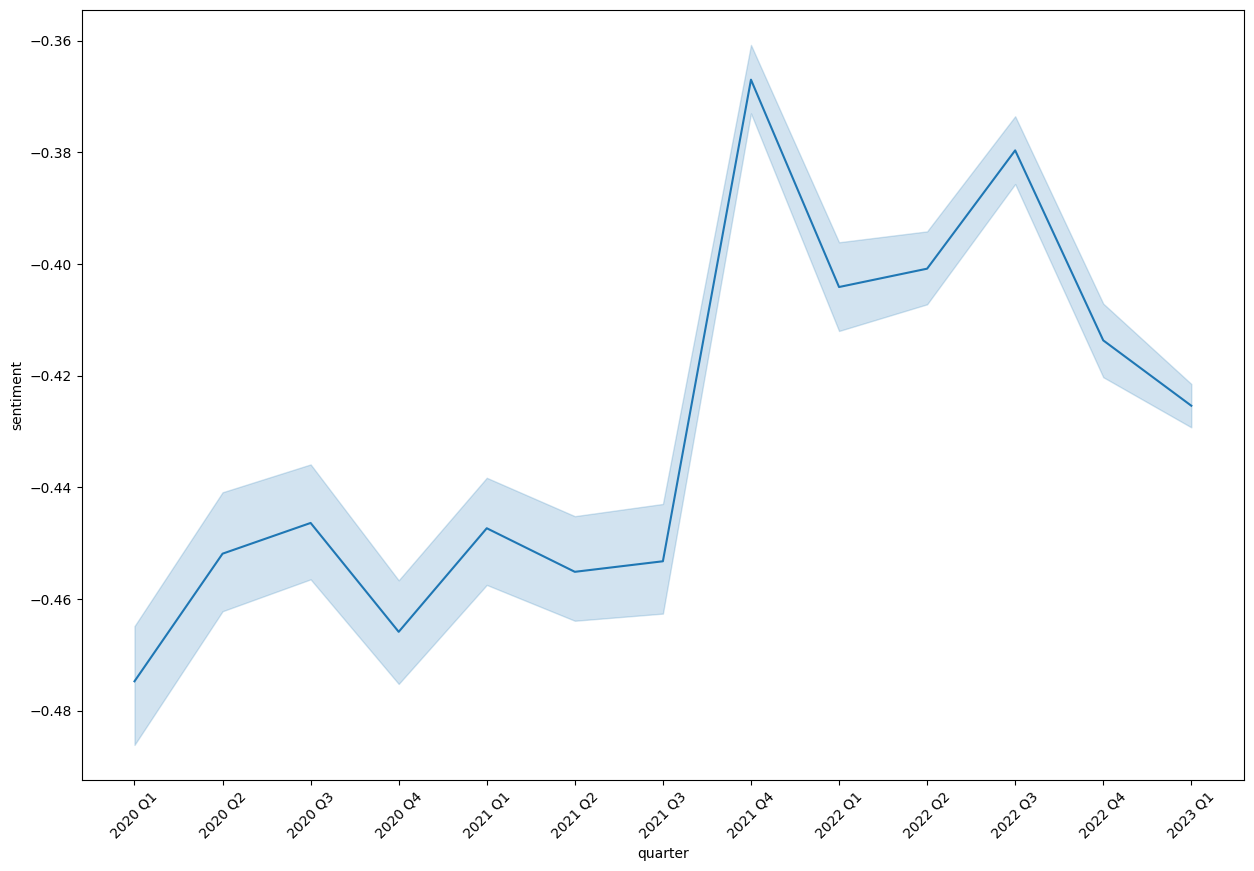

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

tweet_timeline_df = tweet_timeline_df.reset_index(drop=True)

# Combine 'year' and 'month' columns to create 'quarter' column
tweet_timeline_df['quarter'] = tweet_timeline_df['year'].astype(str) + ' Q' + ((tweet_timeline_df['month'] - 1) // 3 + 1).astype(str)

# Sort the dataframe by 'year' and 'month'
tweet_timeline_df = tweet_timeline_df.sort_values(['year', 'month'])

# Define the order of quarters
quarter_order = ['2020 Q1', '2020 Q2', '2020 Q3', '2020 Q4',
                 '2021 Q1', '2021 Q2', '2021 Q3', '2021 Q4',
                 '2022 Q1', '2022 Q2', '2022 Q3', '2022 Q4',
                 '2023 Q1']

# Convert 'quarter' column to categorical with the specified order
tweet_timeline_df['quarter'] = pd.Categorical(tweet_timeline_df['quarter'], categories=quarter_order, ordered=True)

# Set the figure size
plt.figure(figsize=(15, 10))

# Plot the line graph
sns.lineplot(x='quarter', y='sentiment', data=tweet_timeline_df)

# Set the x-axis labels
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [32]:
df_news_recombined.head(1)

,url,date,title,text,tokens,token_text,bert_combined,sentiment
0,http://en.people.cn/n3/2021/0318/c90000-983012...,2021-03-18,Artificial intelligence improves parking effic...,Artificial intelligence improves parking effi...,"['artificial', 'intelligence', 'improves', 'pa...",artificial intelligence improves parking effic...,Peoples Daily Online/Li Wenming Thanks to the ...,-0.111111


In [33]:
pos_text2 = " ".join(df_news_recombined[df_news_recombined['sentiment']==1]['bert_combined'].tolist())
neg_text2 = " ".join(df_news_recombined[df_news_recombined['sentiment']==-1]['bert_combined'].tolist())

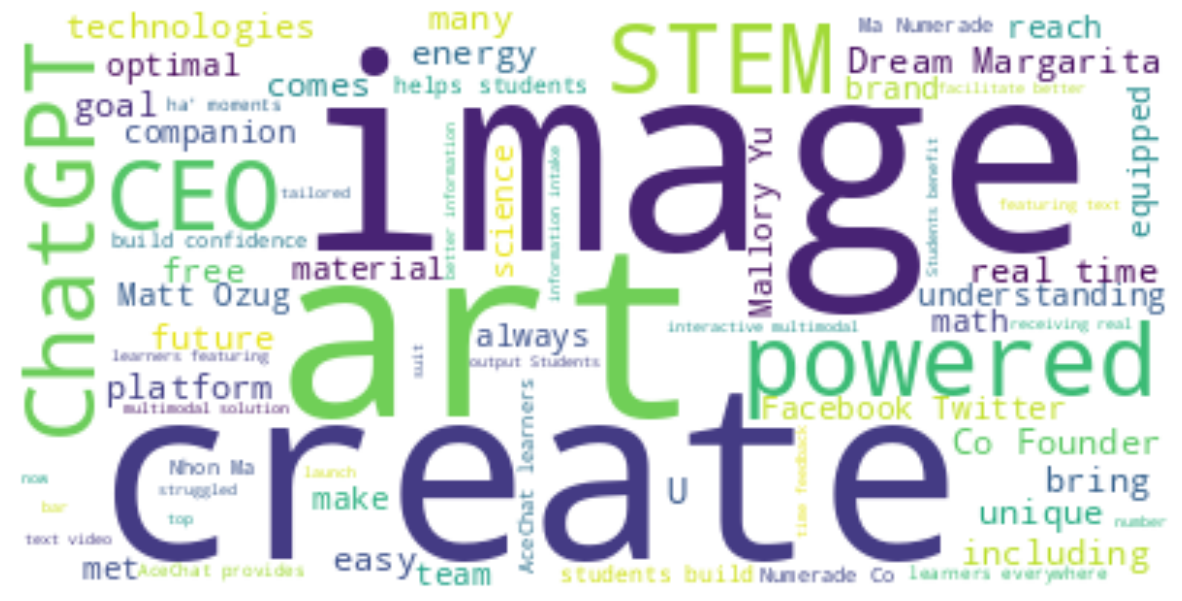

In [34]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['tool','come','first','need',"CA","San","Diego","will","Subscribe","See", "stories","year","Friday","Aug","years","AI",
                  "artificial","intelligence","machine","learning","use","said", "share","company","will","technology","data",
                  "new","best","using","world","app","system","used","work","experience","News","one","help","Sign","Term","terms"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(pos_text2)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

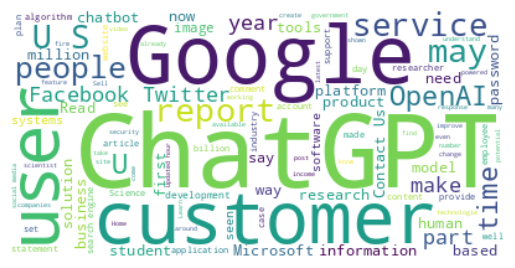

In [35]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['according','tool',"Privacy", "Policy","press", "release","capital", "gains", "Share","net", "investment", "Contact Us","AI",
                  "artificial","intelligence","machine","learning","use","said", "share","company","will","technology","data",
                  "new","best","using","world","app","system","used","work","experience","News","one","help","Sign","Term","terms"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(neg_text2)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=15, use_memory_fs=False)

INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


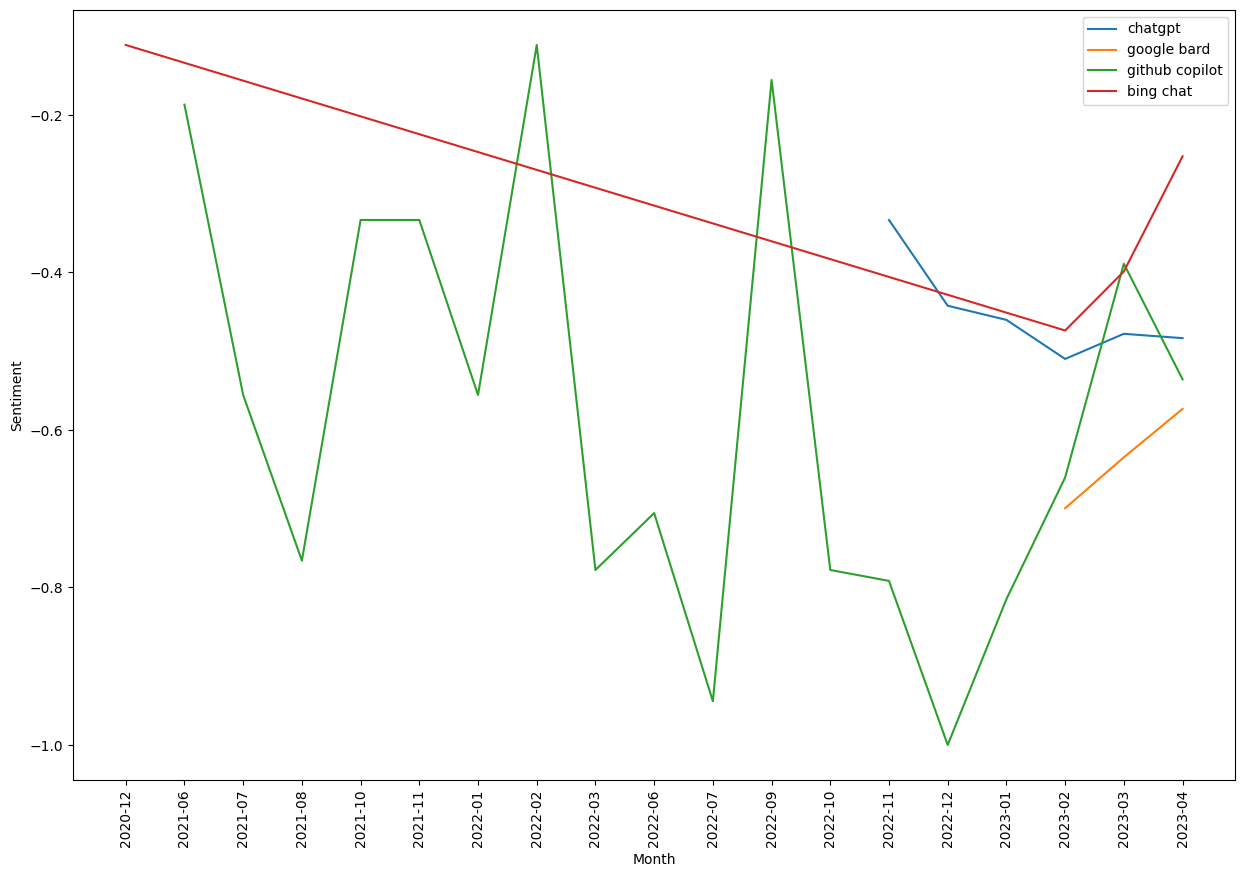

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the keywords
keywords = ['chatgpt', 'google bard', 'github copilot', 'bing chat']

# Function to check if any of the keywords are present in the text
def check_keywords(text):
    global keywords
    for keyword in keywords:
        if keyword in text:
            return keyword
    return None

# Load the data
df = pd.read_csv('df_news_sent.csv')

# Apply the keyword check to create a new column 'keyword'
df['keyword'] = df['token_text'].apply(check_keywords)

# Filter out rows with null keywords
df = df[df['keyword'].notnull()]

# Extract required columns
tweet_timeline_df = df[['date', 'sentiment', 'keyword']].set_index('date')

# Extract month from the date as string
tweet_timeline_df['month'] = pd.PeriodIndex(pd.to_datetime(tweet_timeline_df.index), freq='M').astype(str)

# Calculate the mean sentiment for each month and keyword
sentiment_by_month_keyword = tweet_timeline_df.groupby(['month', 'keyword']).agg({'sentiment': 'mean'}).reset_index()

# Define the order of months
month_order = sorted(tweet_timeline_df['month'].unique())

# Convert 'month' column to categorical with the specified order
sentiment_by_month_keyword['month'] = pd.Categorical(sentiment_by_month_keyword['month'], categories=month_order, ordered=True)

# Sort the dataframe by month
sentiment_by_month_keyword = sentiment_by_month_keyword.sort_values(['month', 'keyword'])

# Set the figure size
plt.figure(figsize=(15, 10))

# Plot separate lines for each keyword
for keyword in keywords:
    keyword_data = sentiment_by_month_keyword[sentiment_by_month_keyword['keyword'] == keyword]
    sns.lineplot(x='month', y='sentiment', data=keyword_data, label=keyword)

# Set the x-axis labels
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Sentiment')
plt.legend()

# Display the plot
plt.show()


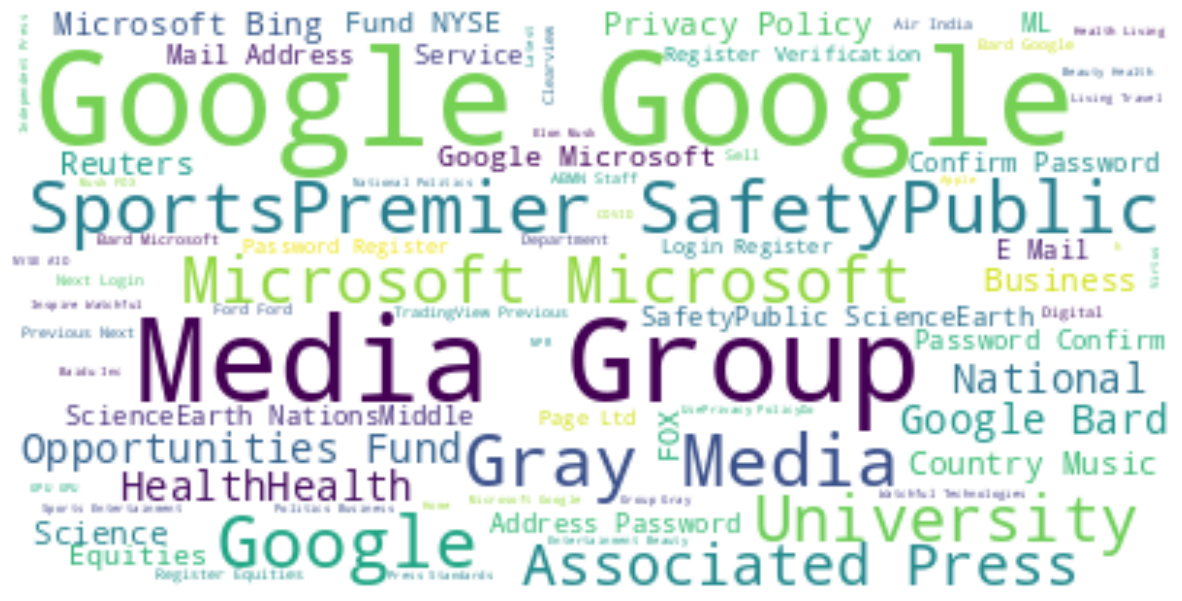

In [38]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import spacy

# Load the spacy NER model
nlp = spacy.load('en_core_web_sm')

# Define a function to extract organizations, people, and locations from text using NER
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG']]
    return entities

# Filter articles with negative sentiment
negative_articles = df_news_recombined[df_news_recombined['sentiment'] == -1]

# Extract entities (organizations, people, and locations) from the negative articles
negative_entities = negative_articles['bert_combined'].apply(extract_entities).explode()

# Filter out non-string values
negative_entities = negative_entities.dropna().astype(str)

# Join the extracted entities into a single string
entity_text = " ".join(negative_entities)

# Create stopword list
stopwords = set(STOPWORDS)
stopwords.update(['U', 'u', 'S', 's', 'tool', 'come', 'first', 'need', "will", "Subscribe", "See", "stories", "year", "Friday",
                  "Aug", "years", "AI", "artificial", "intelligence", "machine", "learning", "use", "said", "share",
                  "company", "will", "technology", "data", "new", "best", "using", "world", "app", "system", "used",
                  "work", "experience", "News", "one", "help", "Sign", "Term", "terms"])

# Generate the word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(entity_text)

# Display the generated image
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


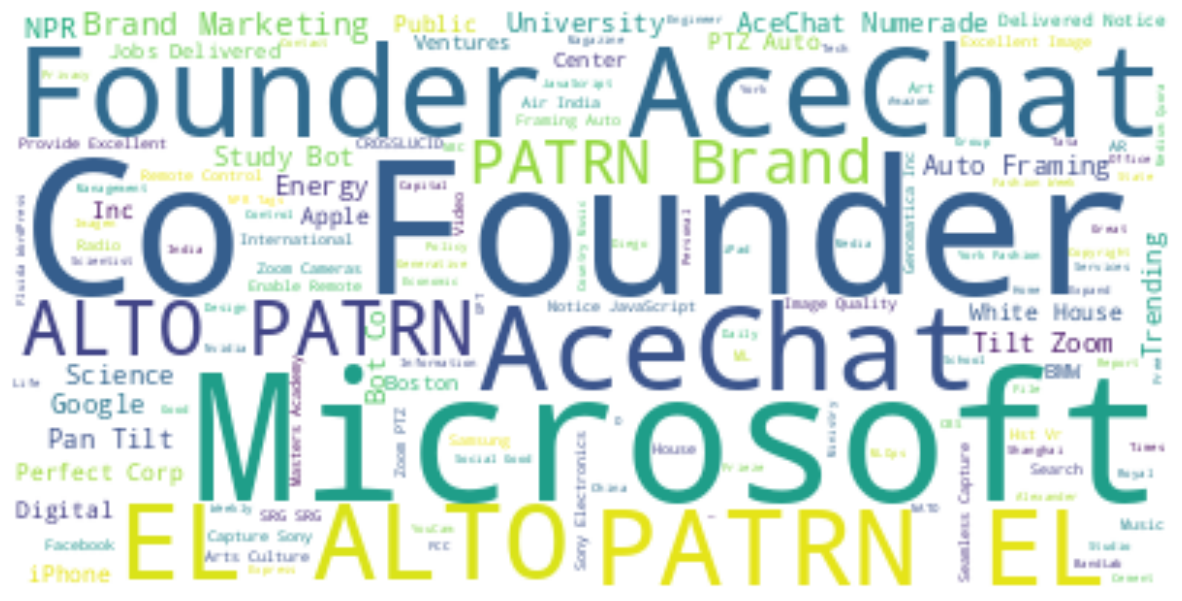

In [39]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import spacy

# Load the spacy NER model
nlp = spacy.load('en_core_web_sm')

# Define a function to extract organizations, people, and locations from text using NER
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG']]
    return entities

# Filter articles with positive sentiment
positive_articles = df_news_recombined[df_news_recombined['sentiment'] == 1]

# Extract entities (organizations, people, and locations) from the positive articles
positive_entities = positive_articles['bert_combined'].apply(extract_entities).explode()

# Filter out non-string values
positive_entities = positive_entities.dropna().astype(str)

# Join the extracted entities into a single string
entity_text = " ".join(positive_entities)

# Create stopword list
stopwords = set(STOPWORDS)
stopwords.update(['U', 'u', 'S', 's', 'tool', 'come', 'first', 'need', "will", "Subscribe", "See", "stories", "year", "Friday",
                  "Aug", "years", "AI", "artificial", "intelligence", "machine", "learning", "use", "said", "share",
                  "company", "will", "technology", "data", "new", "best", "using", "world", "app", "system", "used",
                  "work", "experience", "News", "one", "help", "Sign", "Term", "terms"])

# Generate the word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(entity_text)

# Display the generated image
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()